In [1]:
from datasets.celeba.classification_dataloader import Classification_Dataloader
from image_toolbox.image_utils.visualization_utils import visualize_torch_batch

In [2]:
!pwd

/home/kareem/PycharmProjects/Classification-Pytorch/classification/src


In [3]:
# load configurations
from omegaconf import OmegaConf
conf = OmegaConf.load("../conf/default.yaml")
conf

{'datasets': {'celeba': {'base_url': '/home/kareem/PycharmProjects/Classification-Pytorch/classification/data/celeba', 'exp_name': 'celeba_classification_myCNN', 'zip_file_name': 'img_align_celeba.zip', 'data_dir_name': 'img_align_celeba', 'labels_txt_file': 'identity_CelebA.txt', 'split_txt_file': 'list_eval_partition.txt', 'val_test_r': [0.2, 0.2], 'min_samples_per_class': 5, 'nb_samples': 100}}, 'nets': {'myCNN': {'hparams': {'lr': 0.0001, 'weight_decay': 1e-05, 'filter_size': 3, 'filter_channels': 4, 'n_hidden1': 4096, 'n_hidden2': 2048, 'temperature': 10, 'dropout': 0.0}, 'params': {'num_classes': 9343, 'input_shape': [3, 218, 178]}, 'scheduler_params': {'step_size': 10, 'gamma': 0.5}, 'trainer_params': {'check_val_every_n_epoch': 1, 'fast_dev_run': False, 'max_epochs': 100, 'gpus': 1}, 'early_stopping_params': {'monitor': 'val_acc', 'patience': 20, 'strict': True, 'verbose': False, 'mode': 'max'}, 'checkpoint_params': {'monitor': 'val_acc', 'checkpoint_dir': 'build/checkpoint', '

In [4]:
celeba = Classification_Dataloader(conf=conf, batch_size=16, num_workers=1, image_aug_p=0)
celeba.setup()

size of train, val, test datasets 60 20 20
number of classes in train, val, test datasets 5 5 5


tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 2])
torch.Size([20, 3, 218, 178])



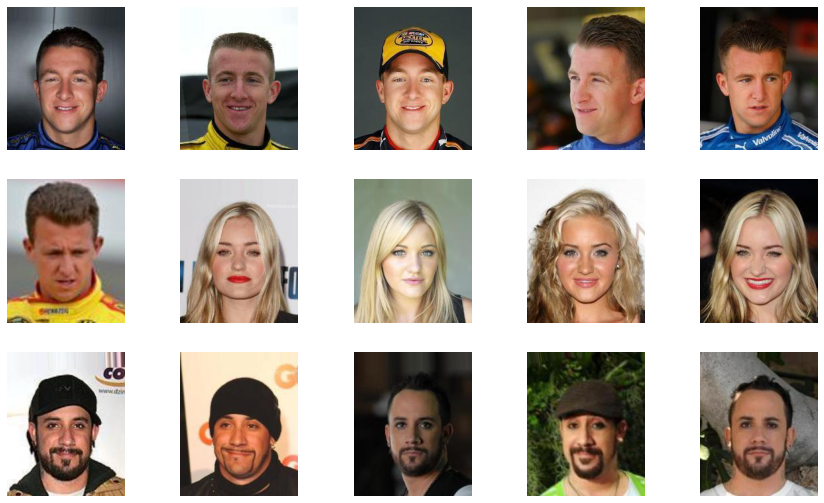

In [8]:
for batch in celeba.val_dataloader():
    imgs, labels = batch
    print(labels[:15])
    print(imgs.shape)
    print()
    visualize_torch_batch(imgs, n_rows=3)
    break

In [6]:
from nets.cnn_net import Classification_Net

model = Classification_Net(conf)

In [7]:
import torch
from torchsummary import summary

if torch.cuda.is_available():
    model.to('cuda')

model_select = conf.nets.select
net_params = conf.nets[model_select]

print()
print('model summary')
print(summary(model, [ (3, net_params.params.input_shape[1], net_params.params.input_shape[2]) ]))
model.cpu()


model summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 218, 178]             112
         MaxPool2d-2           [-1, 4, 109, 89]               0
             PReLU-3           [-1, 4, 109, 89]               1
       BatchNorm2d-4           [-1, 4, 109, 89]               8
            Conv2d-5           [-1, 8, 109, 89]             296
         MaxPool2d-6            [-1, 8, 54, 44]               0
             PReLU-7            [-1, 8, 54, 44]               1
       BatchNorm2d-8            [-1, 8, 54, 44]              16
            Conv2d-9           [-1, 16, 54, 44]           1,168
        MaxPool2d-10           [-1, 16, 27, 22]               0
            PReLU-11           [-1, 16, 27, 22]               1
      BatchNorm2d-12           [-1, 16, 27, 22]              32
           Linear-13                 [-1, 4096]      38,932,480
            PReLU-14    

/home/kareem/PycharmProjects/Classification-Pytorch/venv/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Classification_Net(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): PReLU(num_parameters=1)
      (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): PReLU(num_parameters=1)
      (3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): PReLU(num_parameters=1)
      (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (out): Sequ

In [9]:
from pathlib import Path
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger, MLFlowLogger


early_stop_callback = pl.callbacks.EarlyStopping(
    **conf.nets.early_stopping_params
)

checkpoint_params = conf.nets.checkpoint_params
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor=checkpoint_params.monitor,
    dirpath=str(Path(conf.datasets.celeba.base_url) /  
                checkpoint_params.checkpoint_dir / 
                net_params.exp_name),
    filename=checkpoint_params.filename,
    save_top_k=checkpoint_params.save_top_k,
    mode=checkpoint_params.mode,
)

lr_monitor = pl.callbacks.LearningRateMonitor()

callbacks = [
    early_stop_callback,
    checkpoint_callback,
    lr_monitor,
]

logger = None
if conf.logger_params.logger.lower() == "tensorboard":
    logger = TensorBoardLogger(
        Path(conf.datasets.celeba.base_url) / conf.logger_params.logger_dir, 
        name=net_params.exp_name
    )
elif conf.logger_params.logger.lower() == "mlflow":
    logger = MLFlowLogger(
        experiment_name=net_params.exp_name,
        tracking_uri=str(Path(conf.datasets.celeba.base_url) / conf.logger_params.logger_dir)
    )

trainer = pl.Trainer(**conf.nets.trainer_params, logger = logger, callbacks=callbacks)
trainer.fit(model, celeba)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/kareem/PycharmProjects/Classification-Pytorch/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | conv | Sequential | 1.6 K 
1 | out  | Sequential | 66.5 M
------------------------------------
66.5 M    Trainable params
0         Non-trainable params
66.5 M    Total params
265.923   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/kareem/PycharmProjects/Classification-Pytorch/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Experiment with name celeba_classification_myCNN not found. Creating it.
/home/kareem/PycharmProjects/Classification-Pytorch/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/kareem/PycharmProjects/Classification-Pytorch/venv/lib/python3.8/site-packages/pytorch_lightn

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]